# Histopathologic Cancer Detection

This project is a part of an older Kaggle Competition that can be found [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection).

# Step One: Objective

The objective of this project is to create a model that can reliable classify if an image either has or does not have cancerous tissue present. We are provided two directories of imagery, one to train with and another that we will use to run the final validation on for submission in this competition.

# Step Two: Exploratory Data Analysis & Preprocessing

Before we get to builing a model, I will use this section to explore the data we have to work with and then prepare the data to be pre-processed and loaded by the model. 


## Loading Kaggle Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# If we run the given code below this stalls the run. 
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
print("Loaded...")

Loaded...


## Exploratory Data Analysis

In the cells below I explore some basics about the dataset we're provided via `train_labels.csv`. This csv contains two attributes: Id and Label. The provided id corresponds to a tiff filename in the training data directory. The label is a binary classification indicating if the image associated with the id has cancerous tissue present. The label will show 0 if no cancerous tissue is detected, and will show 1 if cancerous tissue is detected. We also see that there are over 220,000 images available to train with. 

In [3]:
print(f"Entries: {train_labels.shape[0]}\nAttributes: {list(train_labels.columns)}")
train_labels.head()

Entries: 220025
Attributes: ['id', 'label']


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [5]:
labels = train_labels['label'].unique()
print(labels)

[0 1]


Now that we know a bit about the data frame provided, let's take a look at the acutal imagery.

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
def get_image(tif_id: str):
    filename = f'/kaggle/input/histopathologic-cancer-detection/train/{tif_id}.tif'
    return Image.open(filename)

def show_image(image_data, label: int = None, ax=None): 
    if ax is None:
        plt.imshow(image_data)
        if label != None:
            plt.title(f"Classification: {label}")
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(image_data)
        if label != None:
            ax.set_title(f"Classification: {label}")
        shape = np.array(image_data).shape
        ax.text(0, 20, f"Min: {np.min(image_data)} Max: {np.max(image_data)}\nHxW:{shape[0]}x{shape[1]}\nChannels: {shape[2]}", fontsize=10, color='white', bbox=dict(facecolor='black', alpha=0.5))
        ax.axis('off')


def show_images(data: pd.DataFrame, images_per_row:int = 5, rows: int =1) -> None:
    n = images_per_row * rows
    fig, axs = plt.subplots(rows, images_per_row, figsize=(images_per_row*4, rows*4))
    if rows == 1:
        axs = axs.reshape(1, -1)
    for i in range(n):
        tif_id = data['id'][i]
        label = data['label'][i]
        image = get_image(tif_id = tif_id)
        
        row = i // images_per_row
        col = i % images_per_row
        show_image(image, label, ax=axs[row, col])
    plt.show()

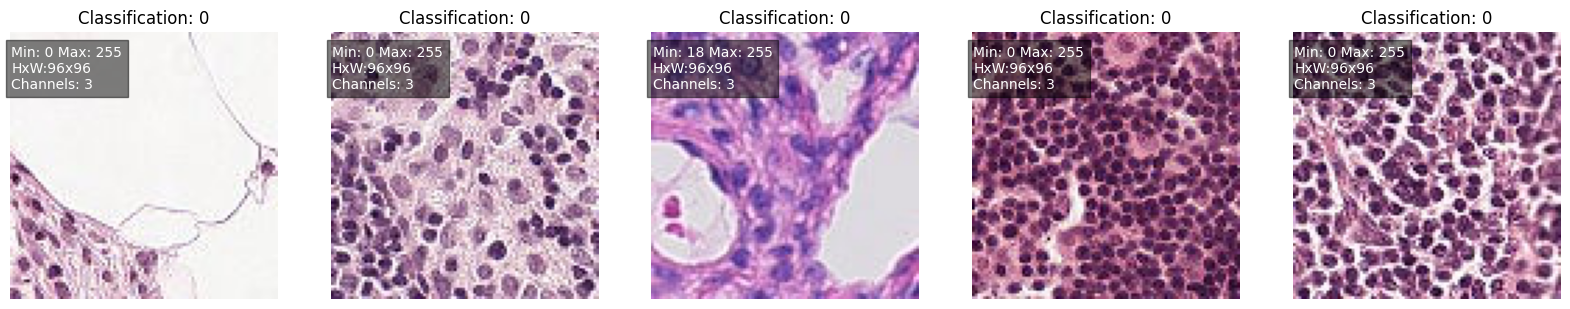

In [7]:
negative = train_labels[(train_labels['label'] == 0)].reset_index(drop=True)
show_images(data = negative)

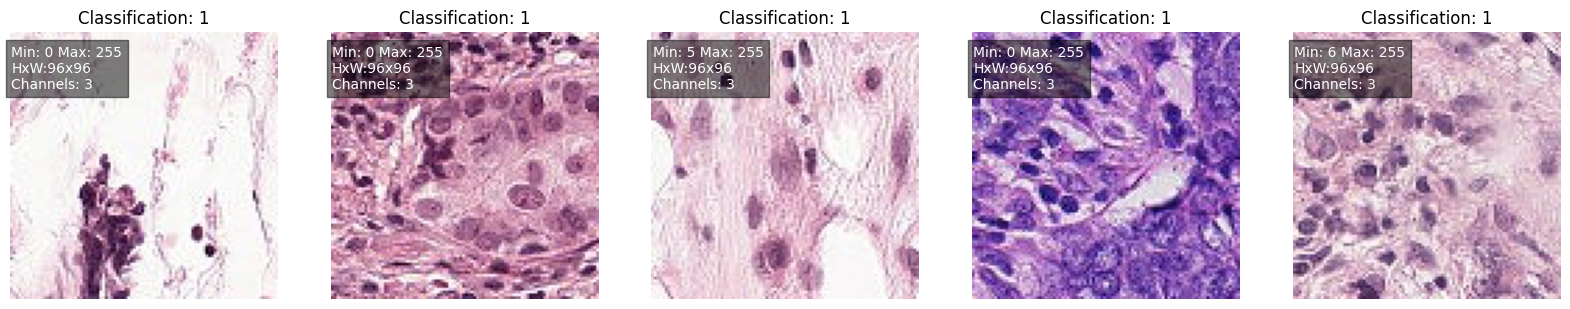

In [8]:
positive = train_labels[(train_labels['label'] == 1)].reset_index(drop=True)
show_images(data = positive)

Above we see that these images are represented by arrays of size 96x96 and have 3 RGB color channels. The values range from 0-255, which makes these images good candidates for normalization as a part of the pre-processing, which will scale it down to values between 0-1.

Next, since we have over 200,000 images to work with we'll need to sample the data we're working with so that we can efficiently train the model on a subset of the data. In order to do this, we'll need to make sure our subset is representative of the original dataset, so below I've plotted the distribution of negative and positive classifications. There appears to be about a 60/40 split so we'll want to confirm the subset we work with has a similar distribution to avoid any biasing the model.

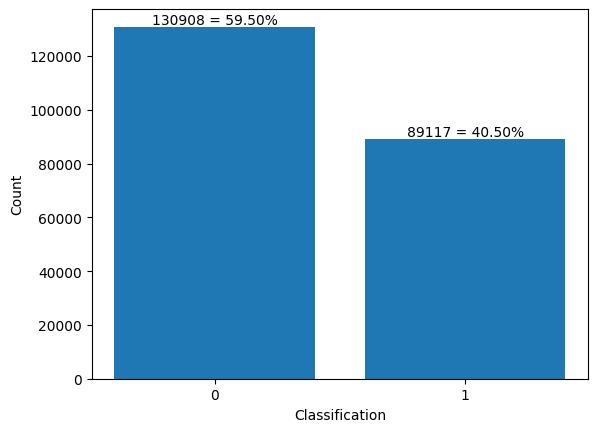

In [9]:
sums = [(train_labels['label'] == l).sum() for l in labels]

plt.bar(labels, sums)
plt.xlabel("Classification")
plt.ylabel('Count')
plt.xticks(labels)
for i, value in enumerate(sums):
    plt.text(i, value + 0.1, f"{value} = {value/train_labels.shape[0]*100:.2f}%", ha='center', va='bottom')
plt.show()

## Data Preparation 

Now that we know some about the data we're working with we can prepare it to be used by the model. Since we're working with images, and not data just stored in memory, we'll need to make use of the Keras object `ImageDataGenerator`. In order to use this, and to prepare the images there are a few things we'll need to do next: 

1. Update `id` column to include .tif file extension so `ImageDataGenerator` can find the data in the directory
2. Update `label` column to be a string so it can be used by the `ImageDataGenerator`
3. Get a representative subset of the data from the training 
4. Build the `ImageDataGenerator` objects for both training and validation - should include normalization 

In [10]:
# Set seed for reproducible results
import tensorflow as tf
import numpy as np
import random
seed = 55

# Set seed for numpy
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


2024-02-22 20:36:05.964865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 20:36:05.964994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 20:36:06.099968: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
img_height, img_width = 96, 96

In [12]:
# To use ImageDataGenerator we need to provide filename not just id
train_labels['id'] = train_labels['id'] + ".tif"

# To use ImageDataGenerator binary mode we need labes to be strings:
train_labels['label'] = train_labels['label'].astype(str)

train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [13]:
# Get subset of samples to work with for training + 
# We have over 200k samples to work with - can limit the number of samples as we're building first model
sample_size = 10000
train_reduced = train_labels.iloc[:sample_size]

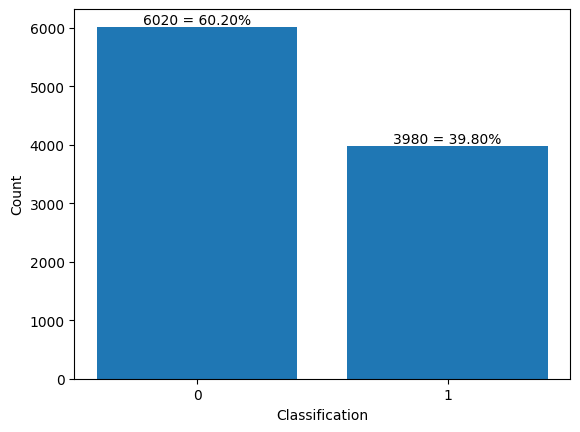

In [14]:
# Confirm distribution is representative of original set (60% zeroes, 40% ones)
sums = [(train_reduced['label'] == str(l)).sum() for l in labels]

plt.bar(labels, sums)
plt.xlabel("Classification")
plt.ylabel('Count')
plt.xticks(labels)
for i, value in enumerate(sums):
    plt.text(i, value + 0.1, f"{value} = {value/train_reduced.shape[0]*100:.2f}%", ha='center', va='bottom')
plt.show()

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
img_height, img_width = 96, 96

# Normalize pixel values 0:1 + enable us to split sampled data to train/validation sets wo work with
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 

start_time = time.time()

print("Train Generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_reduced,
    directory='/kaggle/input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=64,
    class_mode='binary',
    subset='training', 
    color_mode="rgb",
    seed=55
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Train Generator...
Found 8000 validated image filenames belonging to 2 classes.
Elapsed time: 21.30749535560608 seconds


In [16]:
print("Test Generator...")
start_time = time.time()

test_generator = train_datagen.flow_from_dataframe(
    dataframe=train_reduced,
    directory='/kaggle/input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    subset='validation', 
    color_mode="rgb",
    seed=55,
    shuffle=False
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Test Generator...
Found 2000 validated image filenames belonging to 2 classes.
Elapsed time: 4.3351194858551025 seconds


# Step Three: Model Architecture

For setting up the model architecture, I've decided to explore the Conv-Conv-MaxPool structure, because it has been commonly used in CNNs for image classification. This basically just means we have an architecture with n iterations of 2 layers of convolution followed by max-pooling. Once I've got the base model built out I plan to adjust some parameters to see what produces better results - including changing the number of Conv-Conv-MaxPool iterations, number of dense layers, output activation function, and include things like normalization.

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, BatchNormalization


def build_model(convolution_layers: int, fully_connected_layers: int, pooling: str, output_activation:str, two_layers: bool, batch_normalization: bool):
    # Define the model config/layers
    model_config = [Input(shape=(img_width, img_height, 3))]
    filter_size = (3,3)

    for layer in range(convolution_layers):
        units = (2)**(layer+5)
        model_config.append(Conv2D(units, kernel_size=filter_size, activation = 'relu'))
        if two_layers:
            model_config.append(Conv2D(units, kernel_size=filter_size, activation = 'relu'))
        if pooling == 'max':
            model_config.append(MaxPooling2D(pool_size=2))    
        elif pooling == 'avg':
            model_config.append(AvgPool2D(pool_size=2, padding='same'))
        if batch_normalization:
            model_config.append(BatchNormalization())

    model_config.append(Flatten())
    layer_start = fully_connected_layers+4
    for i in range(layer_start, 4, -1):
        units = (2)**(i)
#         print(i, units)
        model_config.append(Dense(units, activation='relu'))

    # Output Layer
    model_config.append(Dense(1, activation=output_activation))
    return Sequential(model_config)


def build_and_fit_model(
    convolution_layers: int, 
    fully_connected_layers: int,
    pooling: str, output_activation:str,
    two_layers: bool, 
    batch_normalization: bool,
    epochs: int,
    optimizer,
):
    model =  build_model(
        convolution_layers=convolution_layers, 
        fully_connected_layers=fully_connected_layers,
        pooling = pooling, 
        output_activation=output_activation,
        two_layers=two_layers,
        batch_normalization = batch_normalization
    )
    
    print(model.summary())
    
    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size
    )
    loss, accuracy = model.evaluate(test_generator)

    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    return (model, accuracy, history)


In [18]:
# Handles model run + saving results

results = pd.DataFrame(columns=['convolution_layers', 'fully_connected_layers', 'pooling', 'output_activation', 'two_layers', 'batch_normalization', 'optimizer', 'accuracy'])
models = []
histories = []

def test_model(model_args) -> None:
    (model, accuracy, history) = build_and_fit_model(**model_args)
    results.loc[len(results)] = {**model_args, 'accuracy': accuracy,}
    models.append(model)
    histories.append(history)
    

In [19]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## Base Model 


In [20]:
model_one_params = {
    'convolution_layers':1, 
    'fully_connected_layers': 1, 
    'pooling': 'max', 
    'output_activation': 'sigmoid',
    'epochs': 5,
    'optimizer':'adam',
    'two_layers': True,
    'batch_normalization': False,
}

test_model(model_one_params)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 67712)             0         
                                                                 
 dense (Dense)               (None, 32)                2166816   
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                        

I0000 00:00:1708634207.926509      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 45s 326ms/step - loss: 1.0422 - accuracy: 0.6410 - val_loss: 0.9469 - val_accuracy: 0.6316
Epoch 2/5
125/125 [==============================] - 13s 106ms/step - loss: 0.6336 - accuracy: 0.7249 - val_loss: 0.5356 - val_accuracy: 0.7621
Epoch 3/5
125/125 [==============================] - 14s 112ms/step - loss: 0.5349 - accuracy: 0.7577 - val_loss: 0.5588 - val_accuracy: 0.7434
Epoch 4/5
125/125 [==============================] - 15s 121ms/step - loss: 0.4997 - accuracy: 0.7751 - val_loss: 0.5145 - val_accuracy: 0.7596
Epoch 5/5
63/63 [==============================] - 3s 49ms/step - loss: 0.5268 - accuracy: 0.7680
Loss: 0.5267577767372131
Accuracy: 0.7680000066757202


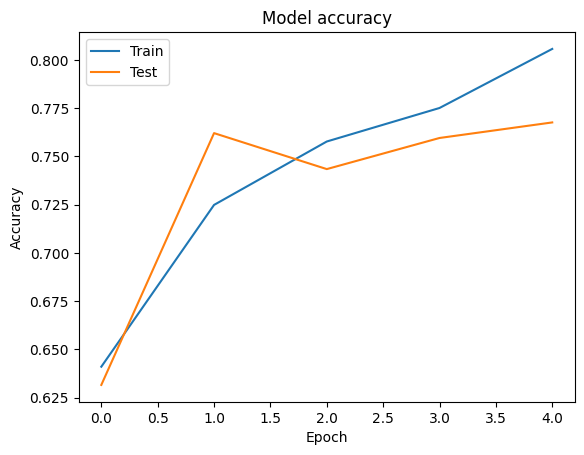

In [21]:
plot_history(histories[0])

In this base model our accuracy is in the mid-70s. Lets move on to tuning the model a bit to see if we can find an optimal structure and set of parameters to increase accuracy. 

# Step Four: Results + Analysis

## Iterating Over Parameters

In the next section I tried some different permutations of inputs to see if I could get and idea of which structures worked best. I commented ou the code because it took a long time to run, but have included a summary of the results below. As we can see the sigmoid activation function does appear to produce the best results, so we'll stick with that. In terms of optimizing structure it seems we perform best when we've got 3 iterations of Conv-Conv-MaxPool and 3 Dense layers before outputting so we'll continue with those as well. 


In [22]:
# model_args = {
#     'convolution_layers':[2,3], 
#     'fully_connected_layers': [2,3,5], 
#     'pooling': 'max', 
#     'output_activation': ['sigmoid', 'tanh', 'softmax'],
#     'epochs': 5,
#     'optimizer':'adam',
# }
# all_args = [dict(zip(model_args.keys(), values)) for values in itertools.product(*model_args.values())]
            
# for arg in all_args:
#     test_model(arg)
            
# results.sort_values(by='accuracy', ascending=False)

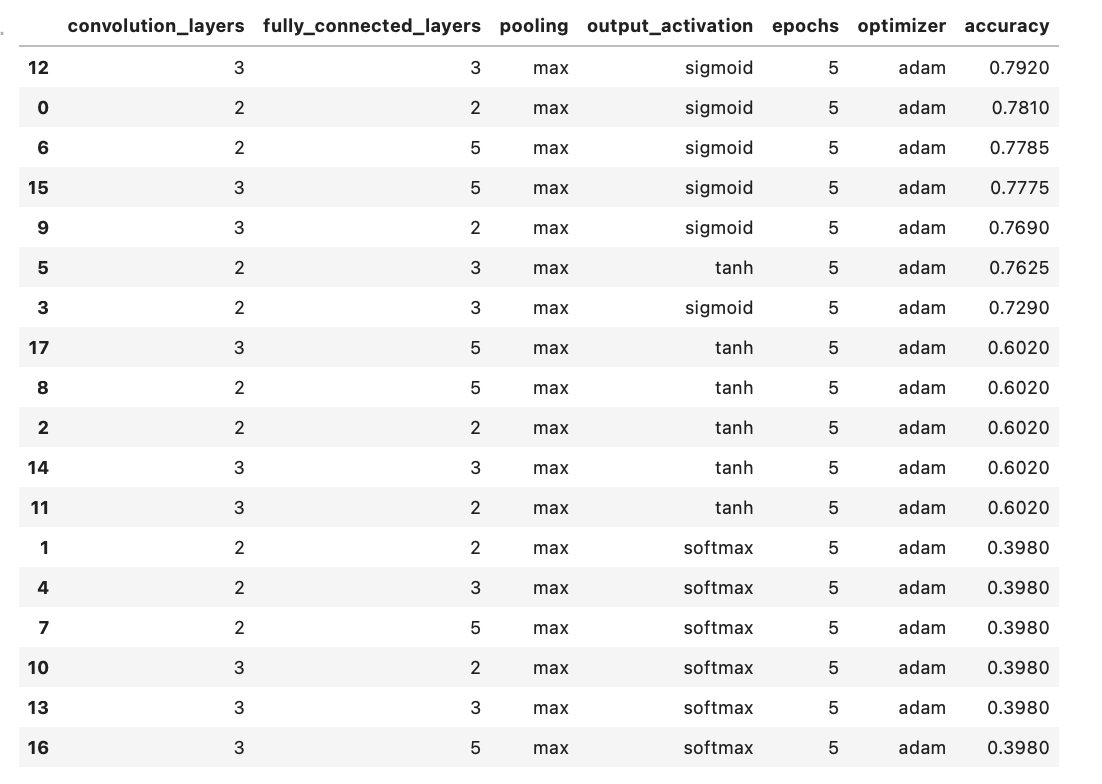

## Changing Optimizer

Previously we've been using the `adam` optimizer, next I'll try a few different ones.

In [23]:
import itertools
model_args = {
    'convolution_layers': [3], 
    'fully_connected_layers': [3], 
    'pooling': ['max'], 
    'output_activation': ['sigmoid'],
    'epochs': [5],
    'optimizer':['sgd', 'rmsprop', 'adam'],
    'two_layers': [True],
    'batch_normalization': [False],
}

all_args = [dict(zip(model_args.keys(), values)) for values in itertools.product(*model_args.values())]
print(f"Testing {len(all_args)}")            
for arg in all_args:
    test_model(arg)
            
results.sort_values(by='accuracy', ascending=False)

Testing 3
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 21, 21, 64)        0         
 g2D)                                       

,convolution_layers,fully_connected_layers,pooling,output_activation,two_layers,batch_normalization,optimizer,accuracy
2,3,3,max,sigmoid,True,False,rmsprop,0.7800
0,1,1,max,sigmoid,True,False,adam,0.7680
3,3,3,max,sigmoid,True,False,adam,0.7585
1,3,3,max,sigmoid,True,False,sgd,0.7515


Though it seems the results are pretty close, the `adam` optimizer does appear to still have the best performance.

## Enabling Batch Normalization

Let's enable Batch Noramlization.

In [24]:
model_args = {
    'convolution_layers': 3, 
    'fully_connected_layers': 3, 
    'pooling': 'max', 
    'output_activation': 'sigmoid',
    'epochs': 5,
    'optimizer': 'adam',
    'two_layers': True,
    'batch_normalization': True,
}

test_model(model_args)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_21 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 46, 46, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_22 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 42, 42, 64)       

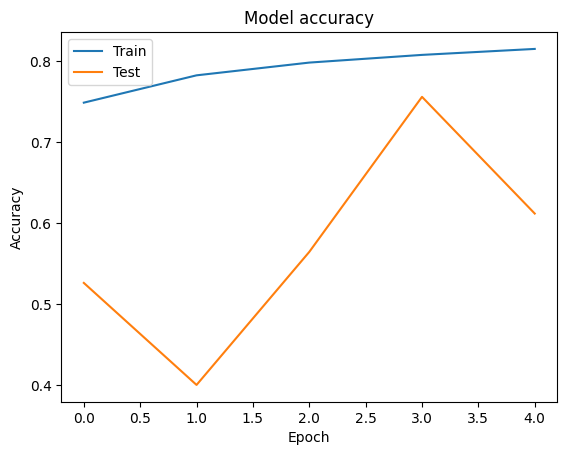

In [25]:
plot_history(histories[-1])

## Switch to Conv-Max Pool 

Next, I'll try adjusting the model structure to only have one Conv Layer instead of two.

In [26]:
model_args = {
    'convolution_layers': 3, 
    'fully_connected_layers': 3, 
    'pooling': 'max', 
    'output_activation': 'sigmoid',
    'epochs': 5,
    'optimizer': 'adam',
    'two_layers': False,
    'batch_normalization': False,
}

test_model(model_args)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 10, 10, 128)      

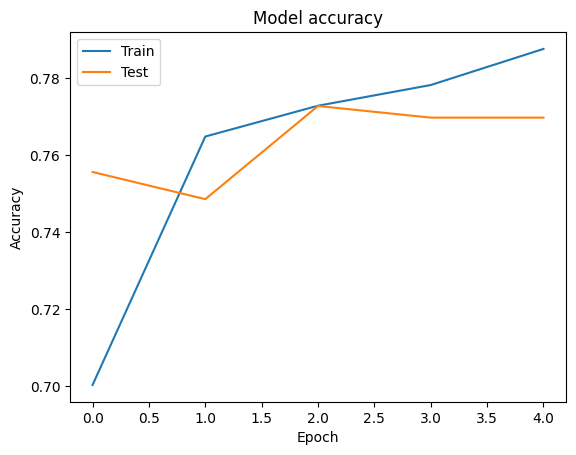

In [27]:
plot_history(histories[-1])

## Summary of Results

The table below summarizes the results (not including the initial parameter permutations shown earlier). 

In [28]:
results.sort_values(by='accuracy', ascending=False)

,convolution_layers,fully_connected_layers,pooling,output_activation,two_layers,batch_normalization,optimizer,accuracy
2,3,3,max,sigmoid,True,False,rmsprop,0.7800
5,3,3,max,sigmoid,False,False,adam,0.7700
0,1,1,max,sigmoid,True,False,adam,0.7680
3,3,3,max,sigmoid,True,False,adam,0.7585
1,3,3,max,sigmoid,True,False,sgd,0.7515
4,3,3,max,sigmoid,True,True,adam,0.6135


# Step Five: Conclusions

In all, I was only able to get accuracy here to about 80%. I found best results when there was a good balance of convolution layers and dense layers. If you add too many of either the performance does start to degrade. As shown above the optimal results were for 3 iterations of Conv-Conv-MaxPool and 3 Dense layers. In general sigmoid activation and using the adam optimizer seemed to perform the best. Overall the results were still not as high as I'd prefer. Time allowing, next steps would be to tune the optimizer and possible run on higher volumes of data and ran more epochs to see if that helps.

convolution_layers              3
fully_connected_layers          3
pooling                       max
output_activation         sigmoid
two_layers                   True
batch_normalization         False
optimizer                 rmsprop
accuracy                     0.78
Name: 2, dtype: object


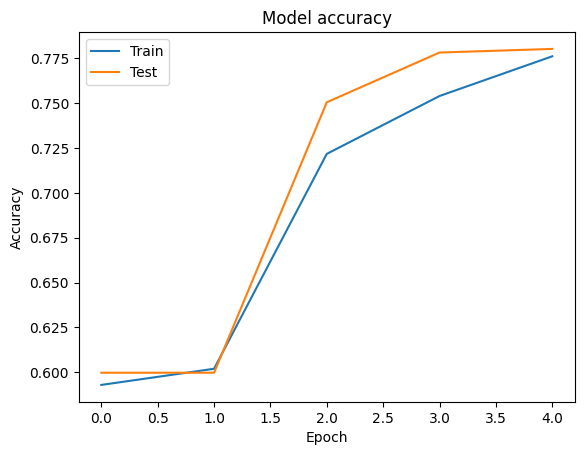

In [29]:
# Best results
max_accuracy_index = results['accuracy'].idxmax()
print(results.loc[max_accuracy_index])
plot_history(histories[max_accuracy_index])

# Predictions for Submission:

In [30]:
def get_validation_files():
    test_dir = "/kaggle/input/histopathologic-cancer-detection/test"
    validation_imgs = os.listdir(test_dir)
    print("Number of test images: {}".format(len(validation_imgs)))
    return validation_imgs

def get_validation_generator(validation_df: pd.DataFrame):
    print("Building Validation Generator...")
    start_time = time.time()
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory="/kaggle/input/histopathologic-cancer-detection/test/",
        x_col='id',
        target_size=(img_width, img_height),
        batch_size=1, # has to be one for predictions
        class_mode=None,
        color_mode="rgb",

    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")
    return validation_generator

def generate_submission_file(validation_df):
    if 'predictions' in validation_df.columns:
        validation_df['label'] = (validation_df['predictions'] > 0.5).astype(int)
    else:
        print("No predictions found, using mock predictions.")
        validation_df['label'] = 0
    submission = validation_df[['id', 'label']]
    submission.loc[:, 'id'] = submission['id'].str.replace('.tif', '')
    submission_filename = 'submission.csv'
    submission.to_csv(submission_filename, index=False)
    print(f"Submission saved as {submission_filename}.")
    
def generate_submission_predictions(final_model, generate_predictions:bool = False) -> None:
    validation_df = pd.DataFrame({'id': get_validation_files()})
    validation_generator = get_validation_generator(validation_df)
    # Running predictions can take a while...
    if generate_predictions: 
        print("Making predictions...")
        validation_df['predictions'] = model_one.predict(validation_generator)
    generate_submission_file(validation_df)

generate_submission = False
if generate_submission: 
    generate_submission_predictions(final_model = models[max_accuracy_index], generate_predictions = False)